In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def funded_ratio(asset_cfs,liability_cfs):
    ratio= asset_cfs.sum()/liability_cfs.sum()
    return "{:.4f}".format(ratio)

In [3]:
def alm(cashflows, yields, delta_y):
    """
    Returns the duration gap where duration is computed using the Effective Duration formula.
    
    Cashflows:dataframe with asset and liability cashflows labeled "Asset CFs" and "Liab CFs"
    yields:   dataframe with columns \'Year\' and \'YC\' where \'YC\' represents base yields
    delta_y:  value in decimal, e.g. 0.005 for 0.5%
    """
    
    #Create yields considering +/- delta_y change
    yields['YC + delta_y']=yields['YC']+delta_y
    yields['YC - delta_y']=yields['YC']-delta_y
    
    #Change yields to discount factors(df)
    t_array=np.array(list(range(1,len(yields)+1)))
    cols=['YC','YC + delta_y','YC - delta_y']
    df=pd.DataFrame([np.exp(-yields[col]*t_array) for col in cols]).transpose()
    
    #Get Present Values
    asset_values=df.multiply(cashflows['Asset CFs'],axis=0).sum()
    liab_values=df.multiply(cashflows['Liab CFs'],axis=0).sum()
    
    #Computation Duration and Duration Gap
    asset_dur=(asset_values['YC - delta_y']-asset_values['YC + delta_y'])/(2*delta_y*asset_values['YC'])
    liab_dur=(liab_values['YC - delta_y']-liab_values['YC + delta_y'])/(2*delta_y*liab_values['YC'])
    dur_gap=asset_dur-liab_dur
    
    #Set as First Output
    out1={'Labels':['Asset Duration','Liability Duration','Duration Gap'],
        'Values':[round(asset_dur,4), round(liab_dur,4),round(dur_gap,4)]}
    
    #Add Stress Scenarios
    stress_y=pd.Series([-0.01,-0.025,-0.05,0.01,0.025,0.05])
    #labels
    labels=['{:.2f}%'.format(lbl*100) for lbl in stress_y]
    
    #Compute MV change
    MV_change_a=-asset_dur*stress_y*asset_values['YC']
    MV_change_l=-liab_dur*stress_y*liab_values['YC']
    
    #Set as Second Output
    out2=pd.DataFrame({'Rate Change Expectation':labels,
             'Asset Movement':round(MV_change_a,2),
             'Liab Movement': round(MV_change_l,2),
             'Net Movement (A-L)':round(MV_change_a-MV_change_l,2)
             })
    
    #Add remarks as guidance
    out2['Remark']=np.where(out2['Net Movement (A-L)']>0,"Benefits Balance Sheet.","Increase Asset Duration.")
    
    return pd.DataFrame(out1),out2

In [4]:
yields=pd.read_csv("sample_yc_using_SW.csv")
yields.rename(columns={"Unnamed: 0":'Year'},inplace=True)
cfs=pd.read_csv("sample CFs.csv")
cfs.fillna(0,inplace=True)
#Set change in yield as 0.5%
delta_y=0.005 

In [5]:
funded_ratio(cfs['Asset CFs'],cfs['Liab CFs'])

'1.0252'

This sample fund is fully funded at >=1 funded ratio.

In [6]:
out1,out2=alm(cfs,yields,delta_y)
out1

,Labels,Values
0,Asset Duration,4.4094
1,Liability Duration,22.6609
2,Duration Gap,-18.2515


The Liability Duration is much longer than the asset duration.

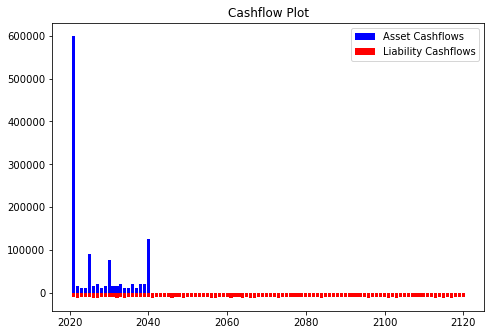

In [7]:
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis=cfs['Year']
y_axis=cfs['Asset CFs']
ax.bar(x_axis,cfs['Asset CFs'],color='b')
ax.bar(x_axis,-cfs['Liab CFs'],color='r')
ax.legend(['Asset Cashflows','Liability Cashflows'])
ax.set_title('Cashflow Plot')
plt.show()

This plot shows the liability extends all the way to 100 years hence the long duration.

In [8]:
out2

,Rate Change Expectation,Asset Movement,Liab Movement,Net Movement (A-L),Remark
0,-1.00%,40828.39,58428.51,-17600.12,Increase Asset Duration.
1,-2.50%,102070.97,146071.28,-44000.31,Increase Asset Duration.
2,-5.00%,204141.93,292142.55,-88000.62,Increase Asset Duration.
3,1.00%,-40828.39,-58428.51,17600.12,Benefits Balance Sheet.
4,2.50%,-102070.97,-146071.28,44000.31,Benefits Balance Sheet.
5,5.00%,-204141.93,-292142.55,88000.62,Benefits Balance Sheet.


This table shows a quick remark on your portfolio given the expected rate change.